In [404]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [405]:
gdf_zones = gpd.read_file('Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

In [409]:
entity_graph = src.graph.graph_from_json('Outputs/entity_atlas_california.json')

In [410]:
keep = (
    list(graph_cities.nodes) +
    [k for k, v in entity_graph._node.items() if 'Tesla' in v.get('network', '')]
)

entity_graph = src.graph.subgraph(entity_graph, keep)

In [411]:
for n in entity_graph._node.values():
    
    n['distance'] = 0
    n['time'] = 0
    n['price'] = 0

for s, a in entity_graph._adj.items():
    keep = {}
    for t, l in a.items():

        l['price'] = 0
            
        if 'station' not in s:
            keep[t] = l

        elif 'station' not in t:
            keep[t] = l

        elif 'station' in s:
            if 'station' in t:
                if l['distance'] >= 200e3:
                    keep[t] = l
    
    entity_graph._adj[s] = keep

In [412]:
deep_reload(src)

veh = src.routing.ConstrainedVehicle(
    n_cases = 30,
    risk_attitude = (0, 1),
    efficiency = 536.4,
    rate = 170e3,
)

In [413]:
deep_reload(src)

reliability = .97

nn = 0

for node in entity_graph._node.values():

    if 'n_dcfc' in node.keys():

        if node['n_dcfc'] > 0:
            nn += 1

        charger = src.routing.Charger(
            veh,
            reliability = reliability,
            n = node['n_dcfc'],
            rate = 170e3,
        )

        node['functions'] = charger.functions

In [414]:
filename = 'cities.json'

graph_cities = src.graph.graph_from_json(filename)
origin_nodes = ['Fresno']
destination_nodes = list(graph_cities.nodes)

for n in destination_nodes:
    
    entity_graph._node[n]['min_soc'] = .5

In [415]:
deep_reload(src)

t0 = time.time()

expectations, values, paths = veh.routes(
    entity_graph,
    origins = origin_nodes,
    destinations = destination_nodes,
    return_paths = True
)

time.time() - t0

9.939841985702515

In [416]:
pkl.dump(
    [expectations, values, paths],
    open('Outputs/Tesla_Model_3_Fresno_Neutral.pkl', 'wb')
)

In [417]:
plot_graph = src.graph.subgraph(entity_graph, list(graph_cities.nodes))

paths_c = [v[1:-1] for k, v in paths.items() if k in graph_cities.nodes]
plot_graph_c = src.graph.subgraph(
    entity_graph, list(np.unique(np.concatenate(paths_c)))
)

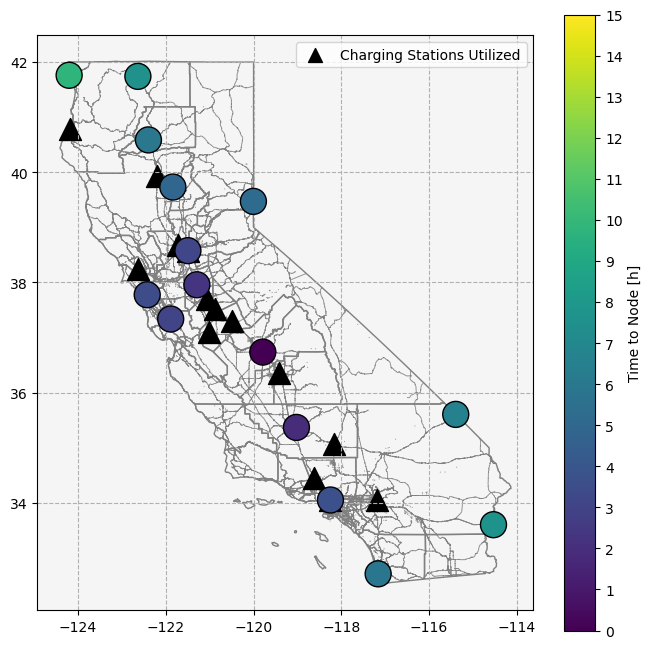

In [418]:
deep_reload(src)

path_values_avg = {}

for target, value in values.items():

    path_values_avg[target] = {}

    for key, val in value.items():

        path_values_avg[target][key] = src.routing.super_quantile(val, (0, 1))

fig, ax  = plt.subplots(figsize = (8,8))

key = 'time_nc'

for source, node in plot_graph._node.items():

		try:
			node['plot'] = path_values_avg[source][key] / 3.6e3

		except:
			node['plot'] = np.nan

gdf_zones_california.plot(ax = ax, ec = 'gray', fc = 'none')

kwargs = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 350,
        'ec': 'k',
        'zorder': 2,
        'vmin': 0,
        'vmax': 15,
    },
    'colorbar': {
        'label': 'Time to Node [h]',
        'ticks': range(0, 16),
    },
    'cmap': src.figures.colormap('viridis'),
}

src.figures.plot_graph(plot_graph, ax = ax, **kwargs)

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'gray',
            'zorder': 0,
		},
		'show_links': False,
	}
src.figures.plot_graph(atlas, ax = ax, **kwargs)

kwargs = {
    'scatter': {
        's': 250,
        'ec': 'k',
        'fc': 'k',
        'label': 'Charging Stations Utilized',
        'zorder': 1,
        'marker': '^',
    },
    'show_links': False,
    'axes': {
        'facecolor': 'whitesmoke',
    }
}

src.figures.plot_graph(plot_graph_c, ax = ax, **kwargs)

_ = ax.grid(ls = '--')
legend = ax.legend()
legend.legendHandles[0]._sizes = [100]

fig.savefig('Paper/figs/R_California_Model_3_Fresno_Neutral.png', bbox_inches = 'tight', dpi = 300)

In [419]:
{k: v['time'] / 3600 for k, v in path_values_avg.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.8185802392052384,
 'Stockton': 2.3190517545725915,
 'San Jose': 3.0091627816627864,
 'Sacramento': 3.13383158122742,
 'San Francisco': 3.5380816006029505,
 'Los Angeles': 3.745267228264059,
 'Chico': 5.044407950960505,
 'I-80 to Reno (State Line)': 5.34273732538696,
 'San Diego': 6.1525164211587775,
 'Redding': 6.213968272980942,
 'I-15 to Las Vegas (State Line)': 6.809457566732687,
 'Yreka': 7.9474345959116715,
 'I-10 to Phoenix (State Line)': 7.9971453940135975,
 'Crescent City': 10.435372079345655}

In [408]:
{k: v['time_nc'] / 3600 for k, v in path_values_avg.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.8185802392052384,
 'Stockton': 2.3190517545725915,
 'San Jose': 3.0091627816627864,
 'Sacramento': 3.13383158122742,
 'San Francisco': 3.4114510643677307,
 'Los Angeles': 3.69127664002664,
 'Chico': 4.914709780959776,
 'I-80 to Reno (State Line)': 5.1873974597932975,
 'San Diego': 5.869172817922824,
 'Redding': 5.923978394290902,
 'I-15 to Las Vegas (State Line)': 6.5481913110038095,
 'Yreka': 7.507552709636051,
 'I-10 to Phoenix (State Line)': 7.559533367866696,
 'Crescent City': 9.728427066760407}

In [346]:
{k: v['time_nc'] / 3600 for k, v in path_values_avg.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.8185802392052384,
 'Stockton': 2.3190517545725915,
 'San Jose': 3.0091627816627864,
 'Sacramento': 3.13383158122742,
 'San Francisco': 3.4114510643677307,
 'Los Angeles': 3.69127664002664,
 'Chico': 4.914709780959776,
 'I-80 to Reno (State Line)': 5.1873974597932975,
 'San Diego': 5.869172817922824,
 'Redding': 5.923978394290902,
 'I-15 to Las Vegas (State Line)': 6.5481913110038095,
 'Yreka': 7.507552709636051,
 'I-10 to Phoenix (State Line)': 7.559533367866696,
 'Crescent City': 9.728427066760407}

In [30]:
entity_graph.number_of_edges()

163351

In [194]:
filename = 'cities.json'

graph_cities = src.graph.graph_from_json(filename)

In [195]:
# Graph containing DC chargers

with open('Data/AFDC/evse_stations.json', 'r') as file:
    evse = json.load(file)

In [196]:
stations_raw = []

for station in evse['fuel_stations']:

    checks = (
        station['state'] == 'CA',
        station['ev_dc_fast_num'] is not None,
        station['access_code'] == 'public',
        station['status_code'] == 'E',
        # (
        #     station['facility_type'] == 'GAS_STATION' or
        #     station['facility_type'] == 'TRAVEL_CENTER' or
        #     station['facility_type'] == 'REST_STOP')
        
    )

    if all(checks):

        stations_raw.append(station)

In [197]:
df_stations = pd.DataFrame.from_dict(stations_raw)

In [391]:
df_stations['ev_network'].unique()

array(['Non-Networked', 'POWERFLEX', 'Blink Network', 'SHELL_RECHARGE',
       'EV Connect', 'Tesla', 'eVgo Network', 'Electrify America',
       'ChargePoint Network', 'Volta', 'EVCS', 'EVGATEWAY', 'FLO',
       'EVRANGE', 'RIVIAN_ADVENTURE', 'CHARGELAB', 'SWTCH', '7CHARGE',
       'CIRCLE_K', 'LOOP'], dtype=object)

In [198]:
node_attributes = {
    'x': 'lambda n: n["longitude"]',
    'y': 'lambda n: n["latitude"]',
    'n_dcfc': 'lambda n: n["ev_dc_fast_num"]',
    'n_acl2': 'lambda n: n["ev_level2_evse_num"]',
    'network': 'lambda n: n["ev_network"]',
    'name': 'lambda n: n["station_name"]',
    'address': 'lambda n: n["street_address"]',
    'city': 'lambda n: n["city"]',
    'state': 'lambda n: n["state"]',
    'zip': 'lambda n: n["zip"]',
    'access_code': 'lambda n: n["access_code"]',
    'status_code': 'lambda n: n["status_code"]',
    'type': 'lambda n: "station"',
}

nlg = src.graph.nlg_from_dataframe(df_stations, node_attributes)

graph_station = src.graph.graph_from_nlg(nlg)

mapping = {n: f'station_{n}' for n in graph_station.nodes}

graph_station = nx.relabel_nodes(graph_station, mapping)

In [199]:
graph = nx.union(graph_cities, graph_station)

In [200]:
atlas = src.graph.graph_from_json('Outputs/atlas_california.json')

In [201]:
atlas._adj[list(atlas.nodes)[0]]

{1: {'distance': 450.0, 'speed': 17.77777777777778, 'time': 25.3125},
 42152: {'distance': 440.0, 'speed': 17.77777777777778, 'time': 24.75}}

In [202]:
graph_station.number_of_nodes(), graph_cities.number_of_nodes(), atlas.number_of_nodes()

(1906, 15, 59621)

In [396]:
tesla = [k for k, v in graph_station._node.items() if v['network'] == 'Tesla']

npr = (
    [k for k, v in graph_station._node.items() if v['network'] not in \
     ['Tesla', 'RIVIAN_ADVENTURE']]
)

graph_station_t = src.graph.subgraph(graph_station, tesla)

graph_station_npr = src.graph.subgraph(graph_station, npr)

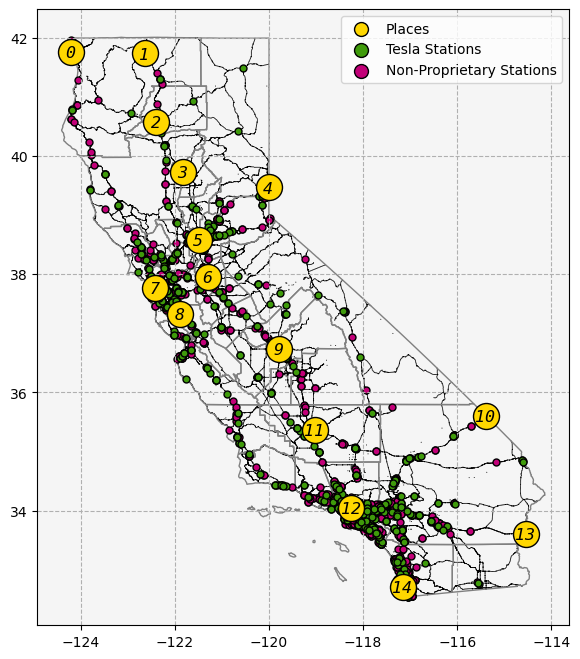

In [403]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (8, 8), squeeze = False)

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 350,
			'ec': 'k',
            'fc': 'gold',
            'label': 'Places',
            'zorder': 3,
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[0, 0], ec = 'gray', fc = 'none')
src.figures.plot_graph(graph_cities, ax = ax[0, 0], **kwargs)
ax[0, 0].legend()
ax[0, 0].grid(ls = '--')

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'k',
            # 'label': 'Roads',
            'zorder': 0,
		},
		'show_links': False,
	}

# gdf_zones_california.plot(ax = ax[1], ec = 'gray', fc = 'none')
src.figures.plot_graph(atlas, ax = ax[0, 0], **kwargs)
ax[0, 0].legend(markerscale = 10)
ax[0, 0].grid(ls = '--')

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'xkcd:grass green',
            'label': 'Tesla Stations',
            'zorder': 2,
		},
		'show_links': False,
        'axes': {
            'facecolor': 'whitesmoke',
        }
	}

src.figures.plot_graph(graph_station_t, ax = ax[0, 0], **kwargs)

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'xkcd:magenta',
            'label': 'Non-Proprietary Stations',
            'zorder': 1,
		},
		'show_links': False,
        'axes': {
            'facecolor': 'whitesmoke',
        }
	}

src.figures.plot_graph(graph_station_npr, ax = ax[0, 0], **kwargs)


legend = ax[0, 0].legend()
legend.legendHandles[0]._sizes = [100]
legend.legendHandles[1]._sizes = [100]
legend.legendHandles[2]._sizes = [100]
ax[0, 0].grid(ls = '--')

idx = 0

for k, v in graph_cities._node.items():

    ax[0, 0].text(
        v['x'] - .015, v['y'] - .015, idx,
        horizontalalignment = 'center', verticalalignment = 'center',
        fontfamily = 'monospace', fontsize = 'large', fontstyle = 'italic',
    )

    idx += 1

fig.savefig('Paper/figs/California_Places_Chargers.png', bbox_inches = 'tight', dpi = 300)

In [48]:
graph_station.number_of_nodes(), graph_cities.number_of_nodes(), graph.number_of_nodes()

(1906, 15, 1921)

In [49]:
deep_reload(src)

graph_to_atlas, atlas_to_graph = src.graph.graph_to_atlas(graph, atlas)

In [50]:
graph_to_atlas['Chico']

20261

In [41]:
atlas.number_of_nodes(), atlas.number_of_edges()

(59621, 63677)

In [64]:
keep = list(graph_cities.nodes) + list(np.random.choice(list(graph_station.nodes), 100))

In [65]:
sg = src.graph.subgraph(graph, keep)

In [88]:
deep_reload(src)

weights = {
    "distance": 400e3,
    "time": np.inf
}

t0 = time.time()

ng = src.adjacency.adjacency(
    atlas, graph, weights, compute_all = True, pb_kwargs = {'disp': True})

time.time() - t0

 [------->] (1921/1921) 100.00%, 6.37 it/s, 301.76 s elapsed, 0.00 s remaining

309.00715041160583

In [90]:
src.graph.graph_to_json(ng, 'Outputs/entity_atlas_california.json')

In [337]:
deep_reload(src)

weights = {
    "distance": np.inf,
    "time": np.inf
}

t0 = time.time()

ng = src.adjacency.adjacency(
    atlas, graph_cities, weights, compute_all = True, pb_kwargs = {'disp': True})

time.time() - t0

 [------------->] (15/15) 100.00%, 3.48 it/s, 4.60 s elapsed, 0.00 s remaining

4.650503158569336

In [338]:
src.graph.graph_to_json(ng, 'Outputs/entity_atlas_california_cities.json')